# Correlation and complications

## Introduction

Correlation is among the most common statistical tests we perform.  Since our ultimate goal is _inference_ about a system, we naturally would like to know if one process or variable is related to another, potentially indicating a real mechanistic relationship or reasonable association we could use.  Because it is so commonly used, it is a good place to start our statistical journey.  At the same time, there are a number of pitfalls that we should be aware of when calculating and interpreting correlation coefficients, and methods to avoid committing Type I or Type II errors.  

## Moments, Mean, and Variance

That's begin by thinking about moments:  In statistics and probability, _Moments_ typically refer to a set of expectations about our data.  If we can characterize our data as a distribution of its values, then the first moment is the **mean**, the second moment is the **variance**, the third moment is the **skewness** of the distribution, and the fourth moment is the **kurtosis**.

Recall in the first class that we said that statistics give us (quantiative) expectations about the data -- the most likely value, values that are more or less likely, etc.  The first moment, the mean, is therefore the _expected value_, which we calculate as the sum of all our values divided by the number of values in our dataset:

$
\bar{x} = \frac{1}{n}\sum_{i}^{n} x_i
$

Let's do a quick calculation of the mean in a set of not-so random numbers:

In [144]:
import numpy as np
import pandas as pd

# our data consist of the numbers from 1 to 6, inclusive, which we put in a Numpy array
x = np.array([[1,2,3,4,5,6]])

# by the simple definition of the mean, we could calculate the sum and divide by the sample size
print((1 + 2 + 3 + 4 + 5 + 6)/6)

# we could ask Python to help us out a bit by calculating the sum and giving us the sample size
print(x.sum()/x.size)

# We could use the np.mean function with our data as the input
print(np.mean(x))

# or we could use the mean method (or property) on the object (our array of numbers) itself
print(x.mean())


3.5
3.5
3.5
3.5


Not surprisingly, these all return the same answer. 

It is also worth pausing for a moment to ask what happens when we have a missing value in our dataset or 'Not A Number' (NaN):

In [145]:
y = np.array([[1, 2, 3, np.nan, 5, 6]])
y.mean()

nan

Ugh, that's a pain.  You can see that the mean of a vector with a NaN value is returned as NaN.  Missing data are a fact of life -- our sensor broke, our quality control procedures removed a dubious value, the researcher wasn't able to make it to the field that day, a bear ate the sensor, our subject disappeared, etc. etc.  How do we deal with missing values?   There is no single answer to this across all of Python, so when this arises we should always think carefully and evaluate how our code is handling them. 

Fortunately in NumPy itself there are a host of methods that can account for NaNs - for instance, we can use `np.nanmean` to calculate the mean value of $y$ while ignoring the NaN value:

In [146]:
np.nanmean(y)

3.4

Alternatively, we could use `np.isnan` to create a Boolean mask for our array, and then specify that np.mean should only consider those values that are non NaN:

In [147]:
valid = ~np.isnan(y) # basically 'tell me where np.isnan(y) is not a NaN, returns a Boolean list! [[ True  True  True False  True  True]]
print(np.mean(y[valid])) # np.mean as function with the 'valid' Boolean as a index into the array 'y' 
print(y[valid].mean()) # .mean() on object with the 'valid' Boolean as a index into the array 'y' 

3.4
3.4


What about the **second** moment of our data?  This is the _variance_, which tells us something about the _scale_ or _spread_ of our data.  It tells us something about how far away our data are expected to be from the mean:

$
\sigma^2 = \frac{1}{n-1}\sum_{i}^{n} (x_i - \bar{x})^2
$

Variance therefore is the sum of the differences between each individual value in the series and the mean of the series squared, then divided by the sample size less 1 (note that using n-1 instead of just the sample size n gives us what is called the ['unbiased' estimator](https://en.wikipedia.org/wiki/Bessel%27s_correction) of the variance -- unbiased because we are already estimating the mean value from a _sample_, not the complete population in full). 

Once again, we could do this 'by hand', going through each term, subtracting the mean, squaring the difference, summing the difference, and then multipling by the sample size less one. Of course, we could also use [the built-in function for `np.var`](https://numpy.org/doc/stable/reference/generated/numpy.var.html) as well.  And those of you who are matrix algebra fans can think of another way as well.



In [148]:
# do the variance calculation 'by hand'
xi = x - np.mean(x) # first, remove the mean from each of the individual terms
xi2 = xi**2 # or np.square(xi)
xi2sum = np.sum(xi2)
x_var = xi2sum/(x.size-1)

# note that you could just string all this together, too 
x_var2 = np.sum(np.square(x - np.mean(x)))/(np.size(xi)-1)

# or, get Numpy to calcuate the variance for us!
x_var3 = np.var(x,ddof=1) # note that we have to specify the 'Delta Degrees of Freedom' or ddof as '1' to get the unbiased variance

print(x_var,x_var2,x_var3)

3.5 3.5 3.5


Note though that the default for `np.var` is to calculate the _biased_ estimator for some reason, while we typically want the unbiased estimator. We therefore had to specify the `ddof=1` to do that (this tells Python to subtract 1 from the raw sample size).  

Let's briefly look at the standard deviation, which is related to the variance of a vector.   In fact, the standard deviation (another measure of dispersion around the mean) is just the square root of the variance:

$
\sigma = \sqrt{\frac{1}{n-1}\sum_{i}^{n} (x_i - \bar{x})^2}
$

In [149]:
# use the built in function from Numpy
np.std(x,ddof=1)

1.8708286933869707

## Covariance

Thus far we've looked at a single sample or series of numbers.  In this class our data will consist of more than one, perhaps hundreds or thousands of series of data - columns of variables and rows of observations of those variables.  And in many cases we'll want to know how they relate or compare to each other.  Before we get to correlation itself, the concept and measurement of _**covariance**_ therefore is important.  Covariance is a measure of how two series change together -- or how does one set of values changes as the one one does.  Do they go up and down together around their respective mean values (e.g. do they have similar second moments)?  Are they in opposition, with one being relatively high compared to their mean value when the other is anomalously low? Or is there no relationship. 

The covariance of two series $x$ and $y$ having the same length $n$ is defined as:

$
cov(x,y) = \frac{1}{n-1}\sum_{i}^{n} (x_i - \bar{x})(y_i - \bar{y})
$

In words then, we remove the mean from each series, but now instead of squaring that difference (or, getting the product of those centered values with themselves), we get the product of those centered values (anomalies) from each series or column of data.  We then sum these as we did with the variance calculation and multiply by the sample size less one ($n-1$) for an unbiased number.  

Once again, we could do this by hand (and in some of my classes you would), but Numpy also provides us with a built-in function for this, `np.cov`:

In [150]:
# create two new arrays of numbers to work with
x = np.array([-4, -1, 1, 3, 1, 6])
y = np.array([-4, 2, -1, 2, 2, 5])

np.cov(x,y,ddof=1)

array([[11.6,  9. ],
       [ 9. ,  9.6]])

What does this output tell us?  Note that it is a square or matrix.  The covariance (9.0) appears on both of the off-diagonal elements (the same number, the covariance of x and y, is in the upper right and lower left).   On the diagonals are two different numbers.  What do they represent?

If you said 'the variance of the individual series x and y', you're absolutely correct!  So the off-diagonal elements are the covariance of each series with the other (which is the same number), while the diagonal entries (row 1, column 1 and row 2, column 2) are the variances of each series individually (or, if you like, _the covariance of each series with itself!_). 

## Finally, correlation

As we know, correlation like covariance measures the similarity between two different sets of paired values.  The primary difference is that correlation values (often called correlation coefficients) are normalized so that they take a values between -1 (perfectly negatively correlated) to 1 (perfectly correlated), with values closer to zero indicating a weak or no association between the two sets of paired data points.  When we say 'correlation' we often mean the [Pearson Product Moment Correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) although there are other types we'll learn about shortly.  

The correlation is related to the covariance, acheives the normalization by dividing by the variance of each series being compared so that the result of the correlation calculation is a coefficient always falling between -1 and 1.  This gives us a way to quantify the similarity of two series of paired values even if each series have very different levels of dispersion around their respective mean or very different overall magnitudes and absolute values.  We can write the Pearson correlation as:

$
r_{x,y} = \frac{1}{n-1}\sum_{i=1}^n  \Big( \frac{x_i - \bar{x}}{\sigma_x} \Big)  \Big( \frac{y_i - \bar{y}}{\sigma_y} \Big) 
$

As you are probably aware, we evaluate the 'significance' of that correlation with a p-value.  The purpose of significance testing is to evaluate whether the correlation coefficient we calculate is meaningful.  Technically, the p-value is the probability (**p**) of obtaining an effect (**r**) __at least as large as__ the one from the sample, assuming **a null hypothesis of no relationship is true**.  Which is not really what we actually want to know, which is probably more like 'what is the probability of getting this **r** if there is no true relationship?'.  Nevertheless, what we will use the p-value for is a null hypothesis test:  Can we reject a null hypothesis of no significant relationship between the two populations from which our data come at some (pre-determined) $\alpha$ value (e.g. $\alpha<0.05$)?  

To determine the p-value, we first need to calculate the test statistic, _t_:

$
t = r \sqrt{\frac{n-2}{1-r^2}}
$

As you can see, the t statistic will be  function of the strength of the relationship and the number of paired observations we had.  

For the p-value itself -- again, the probability of obtaining an effect at least as large or larger than the one from your sample, assuming a null hypothesis of no relationship is true -- you are determining the probability that the value of a T distribution with the same degrees of freedom is larger than your calculated t statistic from your sample.  If very little of the distribution of that T distribution is larger than your t statistic (e.g. the p value is low) then you may be able to reject the null hypothesis.

Back in the old days, we have to get the p-value by first knowing the t statistic and then degrees of freedom and going to a table in a paper book! 


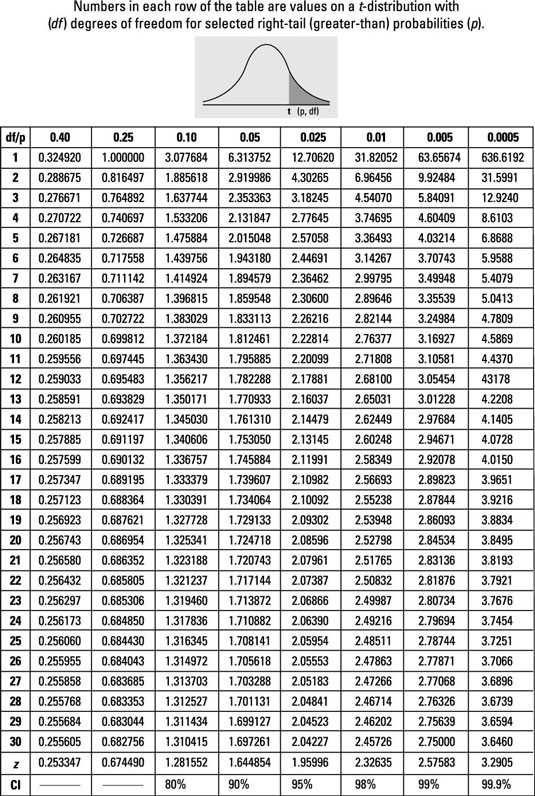


Now we can ask out programming languages to do it for us.  Indeed, the calculation of a p-value to accompany a correlation coefficient is such a standard practice that most built-in correlation functions will do it automatically for you behind the scenes.

As I mentioned, there are often several ways of doing the same or similar calculations in Python, and this is true for correlation.  In fact, we find functions to do correlation in the libraries `NumPy`, `SciPy`, and `Pandas` ... as well as others. 

Probably because `NumPy` is used primarily for numerical calculations, you can get a correlation matrix using [`numpy.corrcoef`](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html), but this function __does not provide significance levels__ to allow you to evaluate the meaningfulness of the correlation coefficient. 

`SciPy` is a statistical library, and so provides several ways of doing correlation, including [`scipy.stats.pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html).  It can calculate correlation and significance but normally for one series against another - that is, it considers just a pair of series at a time and doesn't return a correlation matrix.  

Finally, `Pandas` provides its [own correlation function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) that you can use to operate on `DataFrames`, but does not natively provide significance levels. Pandas also offers [`corrwith'](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corrwith.html) which we'll find usefyl later.  But to get significance levels, we need to use an additional _callable function_ to get them, as I'll show below.

Here is a demonstration of some of these approaches:


In [151]:
# let's get SciPy -- we already have Numpy and Pandas imported
import scipy as sp
from scipy.stats import pearsonr # get the function directly, we'll see why this is usefyl in a moment

# let's put our two simple sets of data into a single 2 column array:
xy = np.vstack((x,y)).T
print(xy)

[[-4 -4]
 [-1  2]
 [ 1 -1]
 [ 3  2]
 [ 1  2]
 [ 6  5]]


In [152]:
# use NumPy to get the correlation, we get a matrix but note that no significance values are returned
corr_np = np.corrcoef(xy[:,0],xy[:,1]) # np.corrcoef(xy,rowvar=False)
print(np.round(corr_np,2))
      
# now with SciPy - we get the same correlation of course, but we do get a significance level as the second returned value
corr_sp = sp.stats.pearsonr(xy[:,0],xy[:,1]) 
print(np.round(corr_sp,2))

# Finally, let's see what Pandas will do - we get a DataFrame with the correlation matrix, but once again no significance level
df1 = pd.DataFrame(xy) # make a Pandas DataFrame from our Numpy array! 
print(np.round(df1.corr(method='pearson'),2))

[[1.   0.85]
 [0.85 1.  ]]
[0.85 0.03]
      0     1
0  1.00  0.85
1  0.85  1.00


All of these different functions do give us similar information - our two test series $x$ and $y$ are correlated at $r=0.85$ and `SciPy` tells us the p-value is $p=0.03$, which we would probably determine was sufficient to reject the null hypothesis and consider this relationship 'significant'.  But none of these approaches are really satisfying to me. What I'd like is a matrix of correlation values, like `NumPy` returns, but I want a similar matrix of significance values so I can evaluate the potential interpretability of a bunch of correlation relationships.  None of the approaches above provide this out of the box, incredibly!  Grumble.

`Pandas` does provide us with one workaround though (we'll see others!).  In addition to being able to specify which correlation methods to use (e.g. `method='pearson'`), Pandas allows us to call another function using the _**lambda**_ approach - see here: https://realpython.com/python-lambda/

In essence, this lets us write new functions on a single line, without having to write an entire function definition.  I won't go into any more detail here for the moment, but combining Panda's correlation method with the Pearson's R calculation in SciPy will get us the two matrices we want:

In [153]:
# first, we ask Panda's corr method to use the lambda function, calling SciPy's pearsonr, and returning only the first output value, the coefficient
correlation_matrix = df1.corr(method=lambda x, y: pearsonr(x, y)[0])

# second, we ask Panda's corr method to use the lambda function, calling SciPy's pearsonr, and returning only the second output value, the p-value
pvalues = df1.corr(method=lambda x, y: pearsonr(x, y)[1])

print(correlation_matrix)
print(pvalues)

         0        1
0  1.00000  0.85286
1  0.85286  1.00000
          0         1
0  1.000000  0.030882
1  0.030882  1.000000


Sort of maddenning, but I guess no language is perfect.  This solution comes from [here](https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance).  

Let's make a quick plot of our data using the excellent `Matplotlib` library:


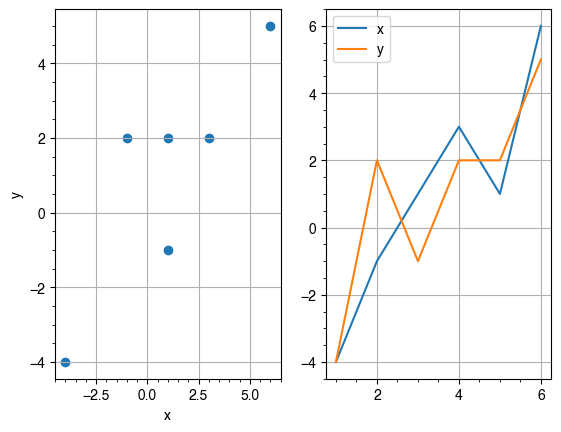

In [154]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Helvetica'

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(xy[:,0], xy[:,1])  # scatter plot on the first axis
ax1.minorticks_on()
ax1.grid()
ax1.set_xlabel('x')
ax1.set_ylabel('y')

lx1,lx2 = ax2.plot(np.arange(1, 7), xy)
ax2.minorticks_on()
ax2.grid()
ax2.legend([lx1,lx2],['x','y'])

plt.show()

## Assumptions of Pearson's product mean correlation and significance testing

When performing a Pearson correlation, there are some explicit assumptions about the data we should be aware of:

1. The variables we are analyzing are continuous (vs. discrete, categorical, or ordinal) -- they can take on any value in a range of numbers
2. The relationship between the variables is expected to be linear (vs. nonlinear, for which we'll need a different test)
3. The variables come from a normal distribution
4. The are no outliers in the dataset

In the real world, our data may violate some (or all!) of these assumptions.  In some cases this indicates that the Pearson correlation is not the appropriate test (see below for dealing with non-linear and non-continuous variables).  In other cases we may need to account for these violations either through modifying (penalizing) our effect size or taking a different approach to calculating significance.  

For significance tests in particular, we have to add another assumption, which is that the _variables are random and independent_.  This may be violated in a number of ways in real data, but one of the ones we are most concerned about will be issues of spatial and temporal autocorrelation -- that some of our data are dependent on others.  In the next class we'll explore the consequences of this and some of the ways to deal with this.  We also need to be mindful of how sample size (and more generally degrees of freedom) affect significance testing. If you look at the calculation of the t statistic above, you see the degrees of freedom are in the numerator, and so very large samples sizes can give significant results for relatively small effect sizes (small values of _r_).  Evaluating whether a significant p-value with a small effect size is 'meaningful', even if 'significant' is important.  This and other drawbacks of p-values has led to a large number of papers questioning their use and value (e.g. [see here](https://www.tandfonline.com/doi/full/10.1080/00031305.2019.1583913)) over the last several years.  We also have to be aware of the statistical consequences of multiple comparisons (running many correlation analyses).  More on these later. 

## Alternative approaches to correlation

There are other approaches to correlation besides Pearson's.  One of the most common is the **Spearman rank correlation** approach, which uses the ranks of the values instead of the values themselves to calculate the effect size (**r**).   Spearman allows for potential non-linear relationships between datasets and mitigate for the influence of outliers in the dataset by first ranking the data (e.g. 1st is the highest value, 2nd is the next highest value, etc) and then calculating the squared difference between the ranks from each data series.  The Spearman correlation coefficient is then a function of the sum of the squared rank differences, and the number of paired data points (e.g. the degrees of freedom).  Because you calculate a correlation coefficient and have a degrees of freedom, you can calculate a p value in the same was as Pearson.  Whereas Pearson correlation is quantifying linear relationships, Spearman can capture potentially non-linear relationships because it is determining the monotonic relationship by using ranks instead of values. 

Spearman is easy to implement in Pandas, simply by passing the method to Pandas `.corr`:

In [155]:
print(np.round(df1.corr(method='spearman'),2))

      0     1
0  1.00  0.77
1  0.77  1.00


In Scipy, there is a [specific function for Spearman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html).  Note here that we get the same Spearman coefficient, but now that we can see the significance level, we see that we would not find this relationship larger than expected if our prior significance level had been $\alpha < 0.05$.   

In [156]:
print(sp.stats.spearmanr(xy)) # alternatively: sp.stats.spearmanr(xy[:,0],xy[:,1])

SignificanceResult(statistic=0.7700513795421217, pvalue=0.07323512813170643)


There are other approaches to correlation as well, including **Kendall's tau coefficient**, which also uses ranking and is often applied to ordinal data.  You can use Kendall's tau from Scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html#scipy.stats.kendalltau) and Panda's (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html).

## Next steps

**Before the next class**, please complete the following:

1. Work through the Matplotlib notebooks to familiarize yourself with some of the plotting functionality in Python
2. Complete the Anscombe's Quartet exercise